In [1]:
import pandas as pd
import quantstats as qs
import numpy as np
import talib

from core.system import *
from core.operation import *
from fredapi import Fred

import warnings

warnings.filterwarnings('ignore')

# Params

In [2]:
# Params
live = True
start = '2005-01-01'
current_date = '2023-01-01'
current_date = date.today().strftime('%Y-%m-%d')
threshold = 2_000_000_000
stock = read_stock(get_large(live) / 'permno_live.csv')

In [3]:
price = pd.read_parquet(get_parquet(live) / 'data_price.parquet.brotli')
market_cap = pd.read_parquet(get_parquet(live) / 'data_misc.parquet.brotli', columns=['market_cap'])

In [4]:
price = price.merge(market_cap, left_index=True, right_index=True, how='left')

In [5]:
price = create_return(price, [1])
price['RET_01'] = price.groupby('permno')['RET_01'].shift(-1)

# Bond + Commodity

In [6]:
# Get return data
def get_ret(ticker_list):
    data = get_data_fmp(ticker_list=ticker_list, start=start, current_date=current_date)
    data = data[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
    data = data.rename(columns={'Adj Close': 'Close'})
    data = create_return(data, [1])
    data = data.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
    data = data.loc[~data.index.duplicated(keep='first')]
    data = data.fillna(0)
    return data

In [7]:
# Get commodity data
com_ticker = ['GLD', 'SLV', 'PDBC', 'USO', 'AMLP', 'XOP']
com = get_ret(com_ticker)

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/ticker]


In [8]:
# Get bond data
bond_ticker = ['BND', 'AGG', 'BNDX', 'VCIT', 'MUB', 'VCSH', 'BSV', 'VTEB', 'IEF']
bond = get_ret(bond_ticker)

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05ticker/s]


In [9]:
bond_comm_port = pd.concat([bond, com], axis=0)

In [10]:
bond_comm_port['vol'] = bond_comm_port.groupby('ticker')['RET_01'].transform(lambda x: x.rolling(5).std().shift(1))
bond_comm_port['inv_vol'] = 1 / bond_comm_port['vol']
bond_comm_port['norm_inv_vol'] = bond_comm_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
bond_comm_port['RET_01'] = bond_comm_port['RET_01'].groupby('ticker').shift(-1)
bond_comm_port['weighted_ret'] = bond_comm_port['RET_01'] * bond_comm_port['norm_inv_vol']
bond_comm_port = bond_comm_port.groupby('date')['weighted_ret'].sum()
bond_comm_port = bond_comm_port.to_frame()
bond_comm_port.columns = ['bond_comm_ret']

<AxesSubplot:xlabel='date'>

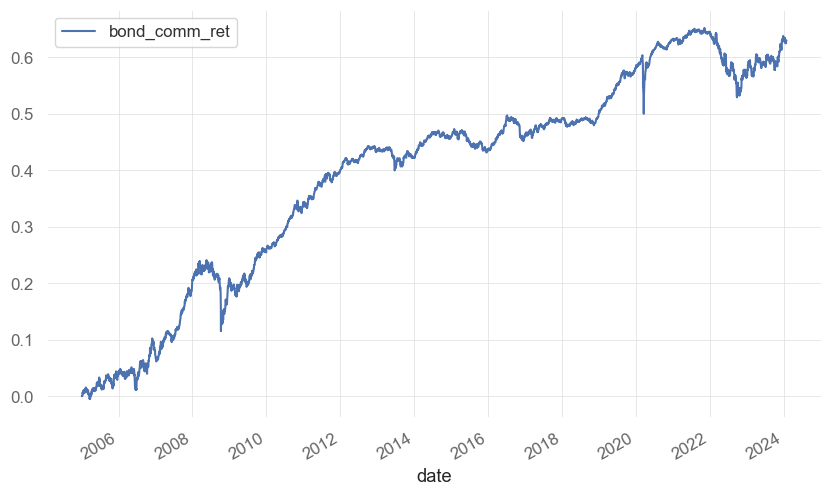

In [11]:
bond_comm_port.cumsum().plot()

# Trend Signal

### Technical

In [12]:
T = [5, 15, 21, 60, 126, 252]

In [13]:
for t in T:
    price[f'sma_{t}'] = price.groupby('permno')['Close'].rolling(t).mean().reset_index(level=0, drop=True)

In [14]:
for t in T:
    price[f'ema_{t}'] = (price.groupby('permno', group_keys=False)
                         .apply(lambda x: talib.EMA(x.Close, timeperiod=t)))

In [15]:
for t in T:
    price[f'rsi_{t}'] = (price.groupby('permno', group_keys=False)
                         .apply(lambda x: talib.RSI(x.Close, timeperiod=t)))

In [16]:
price['obv'] = (price.groupby('permno', group_keys=False)
                .apply(lambda x: talib.OBV(x.Close, x.Volume) / x.expanding().Volume.mean()))

In [17]:
for t in T:
    price[f'atr_{t}'] = (price.groupby('permno', group_keys=False)
                    .apply(lambda x: talib.ATR(x.High, x.Low, x.Close, timeperiod=t)))

In [18]:
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    df['12_ema'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['26_ema'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD_Line'] = df['12_ema'] - df['26_ema']
    df['Signal_Line'] = df['MACD_Line'].ewm(span=signal_window, adjust=False).mean()
    return df

price = price.groupby('permno', group_keys=False).apply(calculate_macd)

### Macro

In [19]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
inflation = fred.get_series("T5YIE").to_frame()
inflation.columns = ['5YIF']
inflation = inflation.shift(1)
date = bond_comm_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
inflation = inflation.reset_index()
inflation = pd.merge_asof(date, inflation, left_on='date', right_on='index', direction='backward')
inflation = inflation.set_index('date').drop('index', axis=1)
inflation = inflation.ffill()

In [20]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
unemploy = fred.get_series("UNRATE").to_frame()
unemploy.columns = ['UR']
unemploy = unemploy.shift(1)
date = bond_comm_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
unemploy = unemploy.reset_index()
unemploy = pd.merge_asof(date, unemploy, left_on='date', right_on='index', direction='backward')
unemploy = unemploy.set_index('date').drop('index', axis=1)
unemploy = unemploy.ffill()

In [21]:
fred = Fred(api_key='00e07a5c98e913ea393c3b1f089e21d1')
yield_curve = fred.get_series("T10Y2Y").to_frame()
yield_curve.columns = ['YIELD']
yield_curve = yield_curve.shift(1)
date = bond_comm_port.index
date = date.to_frame().drop('date', axis=1).reset_index()
yield_curve = yield_curve.reset_index()
yield_curve = pd.merge_asof(date, yield_curve, left_on='date', right_on='index', direction='backward')
yield_curve = yield_curve.set_index('date').drop('index', axis=1)
yield_curve = yield_curve.ffill()

In [22]:
macro = pd.concat([inflation, unemploy, yield_curve], axis=1)

In [23]:
macro['5YIF_z'] = (macro['5YIF'] - macro['5YIF'].mean()) / macro['5YIF'].std()
macro['UR_z'] = (macro['UR'] - macro['UR'].mean()) / macro['UR'].std()
macro['YIELD_z'] = (macro['YIELD'] - macro['YIELD'].mean()) / macro['YIELD'].std()
macro['mt'] = macro[['5YIF_z', 'UR_z', 'YIELD_z']].mean(axis=1)

In [24]:
for t in T:
    macro[f'mt_{t}'] = macro['mt'].rolling(t).mean()

# Trend Portfolio

In [25]:
# SMA Above
sma_above = ((price['sma_21'] > price['Close']))

# SMA Below
sma_below = ((price['sma_5'] < price['Close']) & 
             (price['sma_60'] < price['Close']) & 
             (price['sma_252'] < price['Close']))

# EMA Above
ema_above = ((price['ema_5'] > price['Close']) & 
             (price['ema_60'] > price['Close']) & 
             (price['ema_252'] > price['Close']))

# EMA Below
ema_below = ((price['ema_5'] < price['Close']) & 
             (price['ema_60'] < price['Close']) & 
             (price['ema_252'] < price['Close']))

buy_crossover = (price['ema_60'] > price['ema_252'])
sell_crossover = (price['sma_21'] < price['sma_60'])

# RSI
rsi_buy = ((price['rsi_5'] < 30))

# Market Cap
over_market = (price['market_cap'] > threshold)

# Volume
volume_buy = (price['Volume'] > price['Volume'].rolling(window=60).mean())

# ATR
atr_high = (price['atr_60'] > price['atr_60'].rolling(window=5).mean())

# MACD
macd_buy = (price['MACD_Line'] > price['Signal_Line'])
macd_sell = (price['MACD_Line'] < price['Signal_Line'])

# Macro
macro_buy = (macro['mt_21'] > macro['mt_60'])
macro_buy_df = macro_buy.to_frame()
macro_buy_df.columns = ['macro_buy']

price['signal'] = 0  
price.loc[buy_crossover & volume_buy & rsi_buy & over_market, 'signal'] = 1

In [26]:
def calc_macro_port(row, col1, col2):
    if row['macro_buy']:
        return 0.50 * row[col1] + 0.50 * row[col2]
    else:
        return 0.25 * row[col1] + 0.75 * row[col2]

#### EWP

In [516]:
ewp_port = price[(price['signal'].abs() == 1)]
ewp_port['equal_weight'] = 1
ewp_port['norm_equal_weight'] = ewp_port.groupby('date')['equal_weight'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
ewp_port['weighted_ret'] = ewp_port['RET_01'] * ewp_port['norm_equal_weight'] * ewp_port['signal']
ewp_ret = ewp_port.groupby('date')['weighted_ret'].sum()
ewp_ret = ewp_ret.to_frame()
ewp_ret.columns = ['ewp_ret']

In [517]:
comb_ewp_ret = pd.merge(ewp_ret, bond_comm_port, left_index=True, right_index=True, how='left')
comb_ewp_ret = comb_ewp_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = comb_ewp_ret.columns[0], comb_ewp_ret.columns[1]
comb_ewp_ret['total_ret'] = comb_ewp_ret.apply(calc_macro_port, args=(col1, col2), axis=1)
comb_ewp_total = comb_ewp_ret['total_ret']

#### Inv Vol

In [37]:
def select_top(df, top=35):
    filtered_df = df[df['signal'].abs() == 1]
    return filtered_df.nlargest(top, 'inv_vol')

In [38]:
test = pd.read_parquet(get_parquet(live) / 'data_price.parquet.brotli')
test = create_return(test, [1])
price['norm_ret'] = test['RET_01']
# price['vol'] = price.groupby('permno')['norm_ret'].rolling(252).std().reset_index(level=0, drop=True)
# price['vol'] = price.groupby('permno')['norm_ret'].transform(lambda x: x.rolling(21).std())
price['vol'] = price.groupby('permno')['norm_ret'].transform(lambda x: x.rolling(5).std().shift(1))
price['inv_vol'] = 1 / price['vol']

In [39]:
top_inv_vol_port = price.groupby('date').apply(select_top).reset_index(level=0, drop=True)
top_inv_vol_port['norm_inv_vol'] = top_inv_vol_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
top_inv_vol_port['weighted_ret'] = top_inv_vol_port['RET_01'] * top_inv_vol_port['norm_inv_vol'] * top_inv_vol_port['signal']
inv_vol_ret = top_inv_vol_port.groupby('date')['weighted_ret'].sum()
inv_vol_ret = inv_vol_ret.to_frame()
inv_vol_ret.columns = ['inv_vol_ret']

In [40]:
comb_inv_ret = pd.merge(inv_vol_ret, bond_comm_port, left_index=True, right_index=True, how='left')
comb_inv_ret = comb_inv_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = comb_inv_ret.columns[0], comb_inv_ret.columns[1]
comb_inv_ret['total_ret'] = comb_inv_ret.apply(calc_macro_port, args=(col1, col2), axis=1)
comb_inv_total = comb_inv_ret['total_ret']

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2006-01-03   2006-01-03
End Period                 2024-01-23   2024-01-23
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          289.41%      953.85%
CAGR﹪                     5.33%        9.42%

Sharpe                     0.5          1.57
Prob. Sharpe Ratio         98.14%       100.0%
Smart Sharpe               0.48         1.5
Sortino                    0.71         2.45
Smart Sortino              0.67         2.33
Sortino/√2                 0.5          1.73
Smart Sortino/√2           0.48         1.65
Omega                      1.35         1.35

Max Drawdown               -56.47%      -15.88%
Longest DD Days            1982         377
Volatility (ann.)          19.4%        8.91%
R^2                        0.0          0.0
Information Ratio          0.01         0.01
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-05-20,2008-10-24,2009-03-10,295,-15.880456,-15.221244
2,2020-02-21,2020-03-17,2020-06-08,109,-15.040535,-14.908013
3,2022-03-30,2022-10-13,2023-04-10,377,-10.785929,-10.309809
4,2011-05-02,2011-09-30,2012-02-02,277,-7.993391,-7.780859
5,2018-07-10,2018-10-23,2019-03-11,245,-7.555492,-7.332628


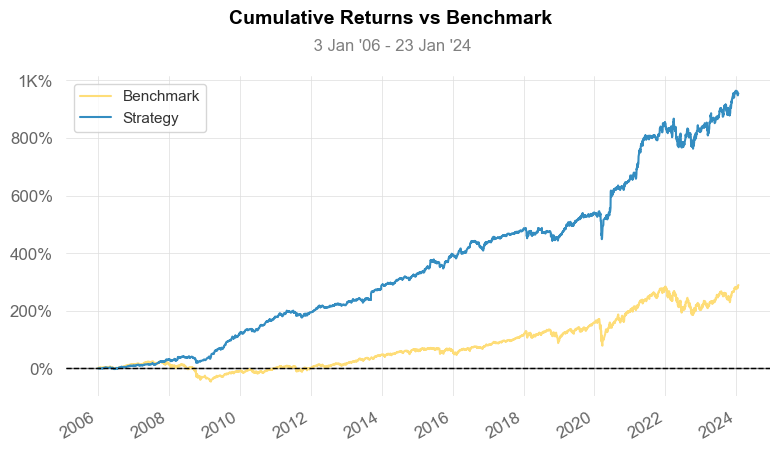

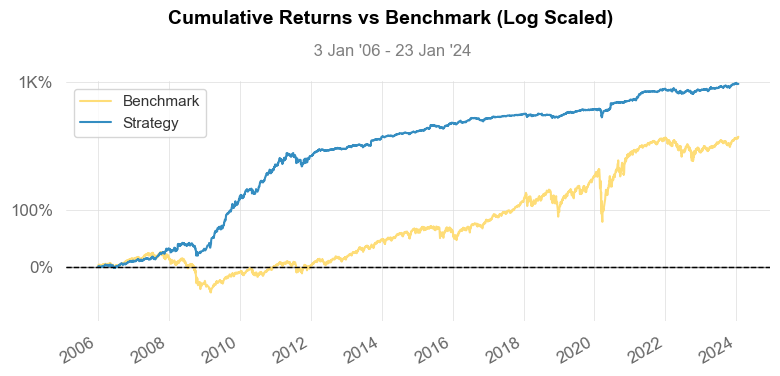

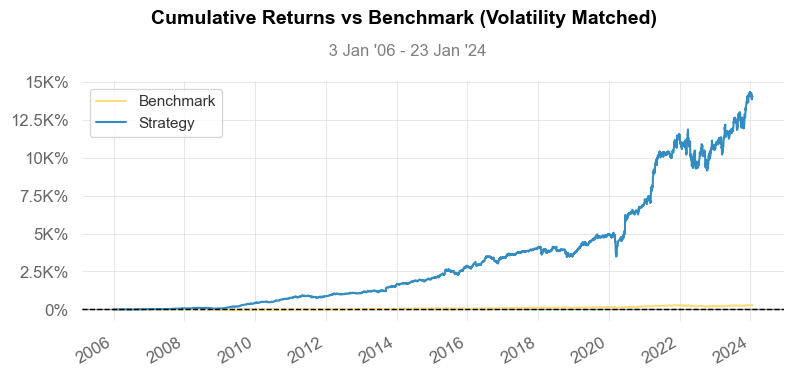

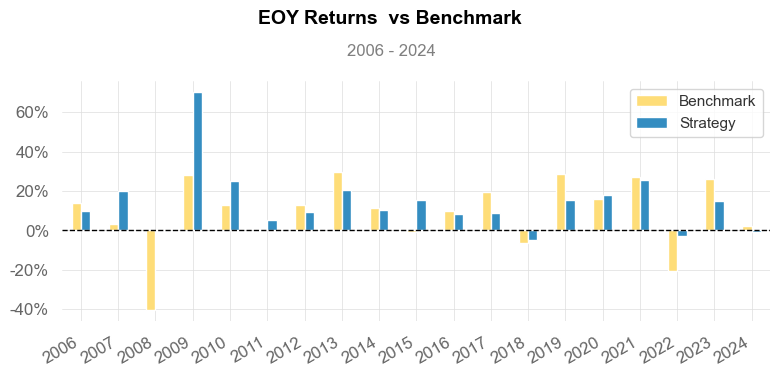

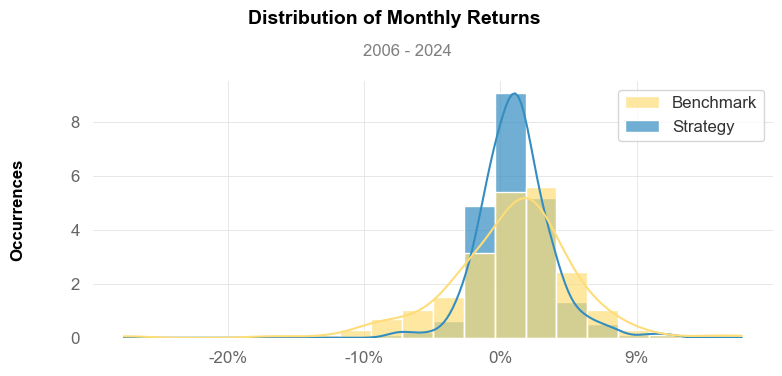

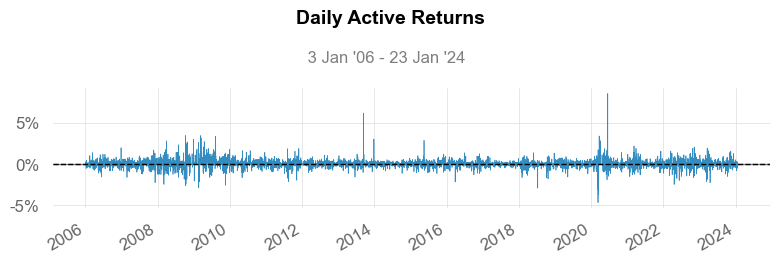

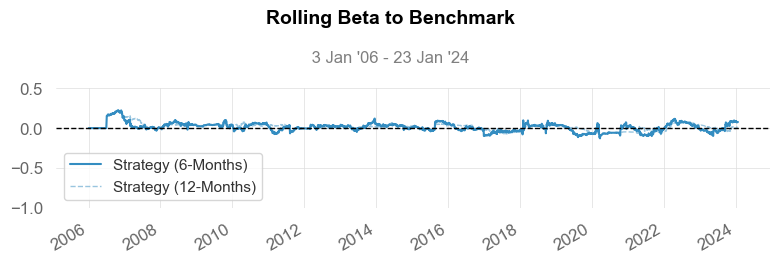

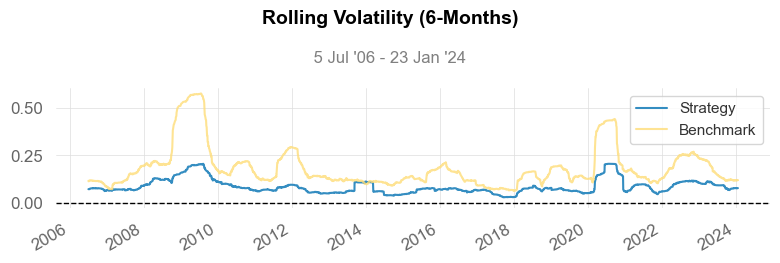

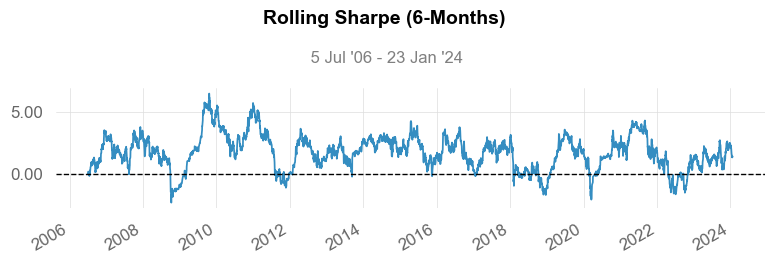

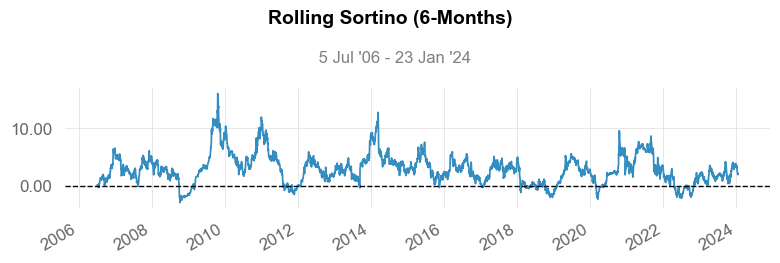

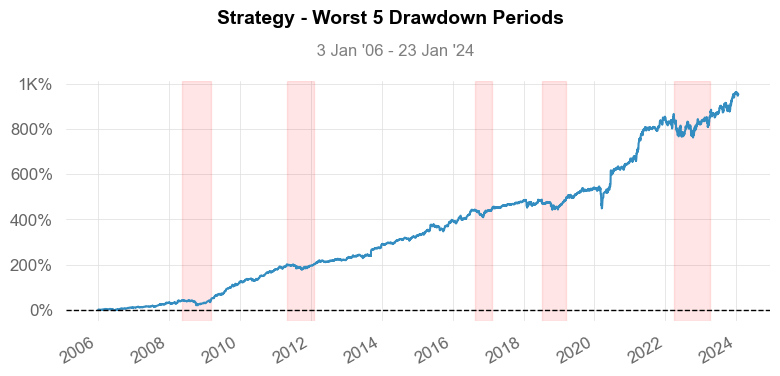

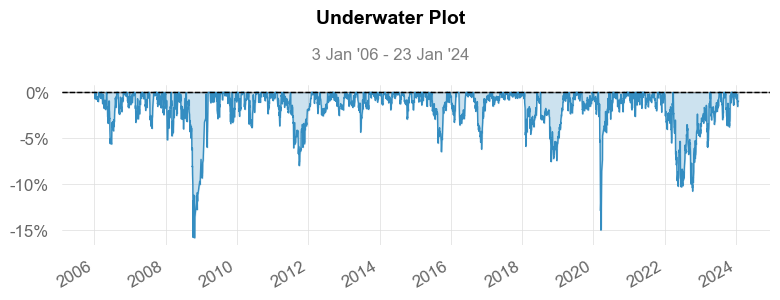

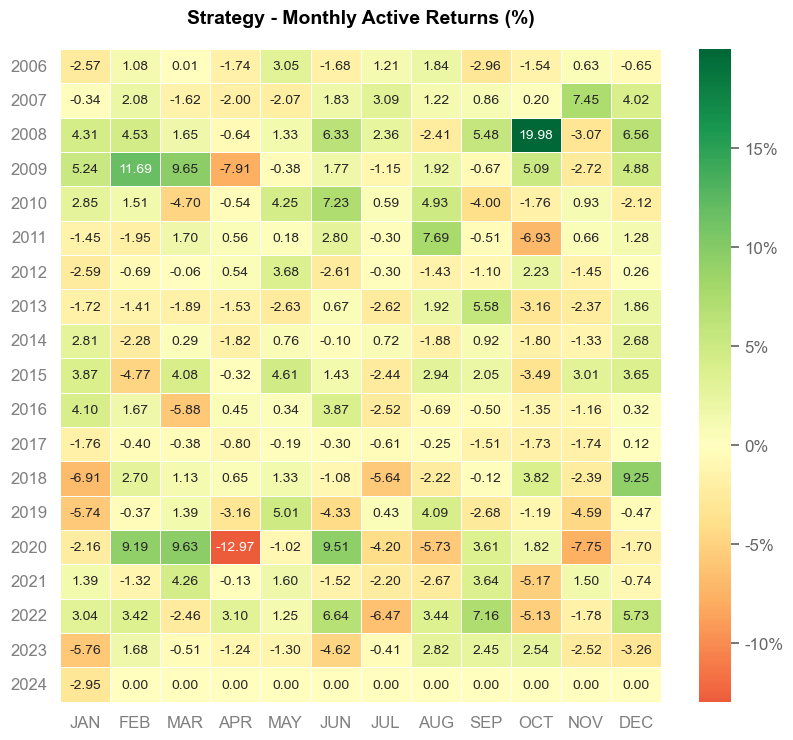

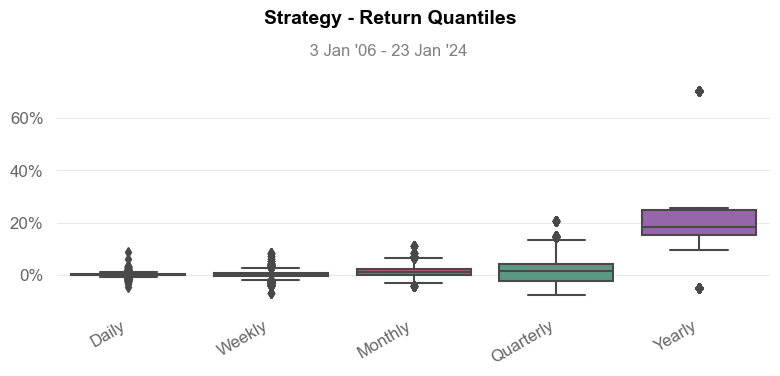

In [41]:
qs.reports.full(comb_inv_total, 'SPY')

# Add Factor

In [497]:
# Function to select top and bottom stocks
def select_top_bottom_stocks(group):
    top_stocks = group.nlargest(25, 'adj_weight')
    bottom_stocks = group.nsmallest(25, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    return top_stocks
    # return pd.concat([top_stocks, bottom_stocks])

# Create Factor-Based Portfolio
def create_factor_port(data, factors, threshold):
    df = data.copy(deep=True)
    # Filtering by Market Capitalization
    df = df[df['market_cap'] >= threshold]
    # Create ranks for each factor
    print("-"*60)
    print("Creating Factor Ranks...")
    for factor_name in factors:
        print(f'Factor: {factor_name}')
        df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)
    # Calculating average rank
    df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)
    # Calculating rank weights
    df['rank_weight'] = (1 / len(factors)) * df['avg_rank']
    # Calculating inverse volatility
    df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
    df['inv_vol_weight'] = 1 / df['vol']
    # Find adjusted weight that accounts for rank and inverse volatility
    df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']
    # Selecting Top and Bottom Stocks
    print("-"*60)
    print("Creating Long/Short portfolio...")
    top_bottom_stocks = df.groupby('date').apply(select_top_bottom_stocks).reset_index(level=0, drop=True)
    # Normalizing Weights
    top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())
    top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']
    total_ret = top_bottom_stocks.groupby('date').total_ret.sum()
    return total_ret

In [473]:
accrual = PrepFactor(live=live, factor_name='factor_accrual', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
accrual = accrual.groupby('permno').shift(3)
comp_debt = PrepFactor(live=live, factor_name='factor_comp_debt', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
comp_debt = comp_debt.groupby('permno').shift(3)
inv_growth = PrepFactor(live=live, factor_name='factor_inv_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
inv_growth = inv_growth.groupby('permno').shift(3)
pcttoacc = PrepFactor(live=live, factor_name='factor_pcttotacc', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
pcttoacc = pcttoacc.groupby('permno').shift(3)
asset_growth = PrepFactor(live=live, factor_name='factor_asset_growth', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
asset_growth = asset_growth.groupby('permno').shift(3)
chtax = PrepFactor(live=live, factor_name='factor_chtax', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
chtax = chtax.groupby('permno').shift(3)
net_debt_finance = PrepFactor(live=live, factor_name='factor_net_debt_finance', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
net_debt_finance = net_debt_finance.groupby('permno').shift(3)
noa = PrepFactor(live=live, factor_name='factor_noa', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
noa = noa.groupby('permno').shift(3)
invest_ppe = PrepFactor(live=live, factor_name='factor_invest_ppe_inv', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
invest_ppe = invest_ppe.groupby('permno').shift(3)
cheq = PrepFactor(live=live, factor_name='factor_cheq', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
cheq = cheq.groupby('permno').shift(3)
xfin = PrepFactor(live=live, factor_name='factor_xfin', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
xfin = xfin.groupby('permno').shift(3)
emmult = PrepFactor(live=live, factor_name='factor_emmult', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
emmult = emmult.groupby('permno').shift(3)
grcapx = PrepFactor(live=live, factor_name='factor_grcapx', group='permno', interval='M', kind='fundamental', stock=stock, div=False, start=start, end=current_date, save=False).prep()
grcapx = grcapx.groupby('permno').shift(3)

Creating factor_accrual ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_comp_debt ---------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_inv_growth --------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_pcttotacc ---------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_asset_growth ------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_chtax -------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_net_debt_finance --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_noa ---------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_invest_ppe_inv ----------------------------- | ✔
Shape: (3104852, 1)
Creating factor_cheq --------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_xfin --------------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_emmult ------------------------------------- | ✔


In [474]:
int_mom = PrepFactor(live=live, factor_name='factor_int_mom', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season = PrepFactor(live=live, factor_name='factor_mom_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
ret_comp = PrepFactor(live=live, factor_name='factor_ret_comp', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()
sb_sector = PrepFactor(live=live, factor_name='factor_sb_sector', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_int_mom ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_mom_season --------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_ret_comp ----------------------------------- | ✔
Shape: (3104852, 5)
Creating factor_sb_sector ---------------------------------- | ✔
Shape: (3104852, 32)


In [475]:
sb_pca = PrepFactor(live=live, factor_name='factor_sb_pca', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_sb_pca ------------------------------------- | ✔
Shape: (3104852, 24)


In [476]:
mom_season_short = PrepFactor(live=live, factor_name='factor_mom_season_short', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_vol = PrepFactor(live=live, factor_name='factor_mom_vol', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_off_season = PrepFactor(live=live, factor_name='factor_mom_off_season', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season6 = PrepFactor(live=live, factor_name='factor_mom_season6', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()
mom_season11 = PrepFactor(live=live, factor_name='factor_mom_season11', group='permno', interval='D', kind='mom', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_mom_season_short --------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_vol ------------------------------------ | ✔
Shape: (3104852, 1)
Creating factor_mom_off_season ----------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season6 -------------------------------- | ✔
Shape: (3104852, 1)
Creating factor_mom_season11 ------------------------------- | ✔
Shape: (3104852, 1)


In [477]:
load_ret = PrepFactor(live=live, factor_name='factor_load_ret', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()
load_volume = PrepFactor(live=live, factor_name='factor_load_volume', group='permno', interval='D', kind='loading', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_load_ret ----------------------------------- | ✔
Shape: (3105599, 5)
Creating factor_load_volume -------------------------------- | ✔
Shape: (3105513, 5)


# Setting Up Data

In [498]:
factor = price[(price['signal'].abs() == 1)]

In [499]:
factor = (pd.merge(factor, sb_sector, left_index=True, right_index=True, how='left')
          .merge(sb_pca, left_index=True, right_index=True, how='left')
          .merge(accrual, left_index=True, right_index=True, how='left')
          .merge(comp_debt, left_index=True, right_index=True, how='left')
          .merge(ret_comp, left_index=True, right_index=True, how='left')
          .merge(inv_growth, left_index=True, right_index=True, how='left')
          .merge(pcttoacc, left_index=True, right_index=True, how='left')
          .merge(int_mom, left_index=True, right_index=True, how='left')
          .merge(mom_season, left_index=True, right_index=True, how='left')
          .merge(asset_growth, left_index=True, right_index=True, how='left')
          .merge(chtax, left_index=True, right_index=True, how='left')
          .merge(net_debt_finance, left_index=True, right_index=True, how='left')
          .merge(noa, left_index=True, right_index=True, how='left')
          .merge(invest_ppe, left_index=True, right_index=True, how='left')
          .merge(cheq, left_index=True, right_index=True, how='left')
          .merge(xfin, left_index=True, right_index=True, how='left')
          .merge(emmult, left_index=True, right_index=True, how='left')
          .merge(grcapx, left_index=True, right_index=True, how='left')
          .merge(mom_season_short, left_index=True, right_index=True, how='left')
          .merge(mom_off_season, left_index=True, right_index=True, how='left')
          .merge(mom_season6, left_index=True, right_index=True, how='left')
          .merge(mom_season11, left_index=True, right_index=True, how='left')
          .merge(load_ret, left_index=True, right_index=True, how='left')
          .merge(load_volume, left_index=True, right_index=True, how='left'))

In [500]:
factor['accruals'] = factor.groupby('permno')['accruals'].ffill()
factor['comp_debt_iss'] = factor.groupby('permno')['comp_debt_iss'].ffill()
factor['inv_growth'] = factor.groupby('permno')['inv_growth'].ffill()
factor['asset_growth'] = factor.groupby('permno')['asset_growth'].ffill()
factor['chtax'] = factor.groupby('permno')['chtax'].ffill()
factor['net_debt_fin'] = factor.groupby('permno')['net_debt_fin'].ffill()
factor['noa'] = factor.groupby('permno')['noa'].ffill()
factor['invest_ppe_inv'] = factor.groupby('permno')['invest_ppe_inv'].ffill()
factor['cheq'] = factor.groupby('permno')['cheq'].ffill()
factor['pct_tot_acc'] = factor.groupby('permno')['pct_tot_acc'].ffill()
factor['xfin'] = factor.groupby('permno')['xfin'].ffill()
factor['emmult'] = factor.groupby('permno')['emmult'].ffill()
factor['grcapx'] = factor.groupby('permno')['grcapx'].ffill()
factor['grcapx1y'] = factor.groupby('permno')['grcapx1y'].ffill()
factor['grcapx3y'] = factor.groupby('permno')['grcapx3y'].ffill()

# Backtest

In [505]:
factors = [
    "XLB_RET_01_sector_01_126",
    "XLE_RET_01_sector_01_126",
    "XLF_RET_01_sector_01_126",
    "XLI_RET_01_sector_01_126",
    "XLK_RET_01_sector_01_126",
    "XLP_RET_01_sector_01_126",
    "XLU_RET_01_sector_01_126",
    "XLV_RET_01_sector_01_126",
    "XLY_RET_01_sector_01_126",
    'PCA_Return_1_ret_pca_01_126',
    'PCA_Return_2_ret_pca_01_126', 
    'PCA_Return_3_ret_pca_01_126',
    'PCA_Return_4_ret_pca_01_126', 
    'PCA_Return_5_ret_pca_01_126',
    "accruals",
    "inv_growth",
    "comp_debt_iss",
    "pct_tot_acc",
    'chtax', 
    'net_debt_fin', 
    'noa',
    'invest_ppe_inv', 
    'cheq', 
    'xfin', 
    'emmult', 
    'grcapx',
    'load_ret_1', 
    'load_ret_2', 
    'load_ret_3', 
    'load_ret_4',
    'load_ret_5',
    "mom_season",
    "mom_season_short",
    "mom_season_6"
]

total_ret = create_factor_port(factor, factors, threshold)
total_ret = total_ret.to_frame()
total_ret.columns = ['factor_ret']

------------------------------------------------------------
Creating Factor Ranks...
Factor: XLB_RET_01_sector_01_126
Factor: XLE_RET_01_sector_01_126
Factor: XLF_RET_01_sector_01_126
Factor: XLI_RET_01_sector_01_126
Factor: XLK_RET_01_sector_01_126
Factor: XLP_RET_01_sector_01_126
Factor: XLU_RET_01_sector_01_126
Factor: XLV_RET_01_sector_01_126
Factor: XLY_RET_01_sector_01_126
Factor: PCA_Return_1_ret_pca_01_126
Factor: PCA_Return_2_ret_pca_01_126
Factor: PCA_Return_3_ret_pca_01_126
Factor: PCA_Return_4_ret_pca_01_126
Factor: PCA_Return_5_ret_pca_01_126
Factor: accruals
Factor: inv_growth
Factor: comp_debt_iss
Factor: pct_tot_acc
Factor: chtax
Factor: net_debt_fin
Factor: noa
Factor: invest_ppe_inv
Factor: cheq
Factor: xfin
Factor: emmult
Factor: grcapx
Factor: load_ret_1
Factor: load_ret_2
Factor: load_ret_3
Factor: load_ret_4
Factor: load_ret_5
Factor: mom_season
Factor: mom_season_short
Factor: mom_season_6
------------------------------------------------------------
Creating Lon

In [506]:
comb_factor_ret = pd.merge(total_ret, bond_comm_port, left_index=True, right_index=True, how='left')
comb_factor_ret = comb_factor_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = comb_factor_ret.columns[0], comb_factor_ret.columns[1]
comb_factor_ret['total_ret'] = comb_factor_ret.apply(calc_macro_port, args=(col1, col2), axis=1)
comb_factor_total = comb_factor_ret['total_ret']

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2006-01-03   2006-01-03
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          253.88%      559.89%
CAGR﹪                     5.01%        7.57%

Sharpe                     0.48         1.52
Prob. Sharpe Ratio         97.55%       100.0%
Smart Sharpe               0.44         1.4
Sortino                    0.67         2.41
Smart Sortino              0.62         2.23
Sortino/√2                 0.47         1.7
Smart Sortino/√2           0.44         1.57
Omega                      1.35         1.35

Max Drawdown               -56.47%      -14.37%
Longest DD Days            1982         378
Volatility (ann.)          19.47%       7.44%
R^2                        0.0          0.0
Information Ratio          0.01         0.01
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-05-22,2008-10-24,2009-02-17,272,-14.369297,-12.776625
2,2020-02-20,2020-03-19,2020-06-04,106,-12.293043,-12.122089
3,2022-03-30,2022-10-11,2023-04-11,378,-10.662301,-10.218954
4,2011-07-06,2011-09-30,2011-12-01,149,-6.204882,-5.947101
5,2021-12-08,2022-03-11,2022-03-23,106,-5.655177,-5.602967


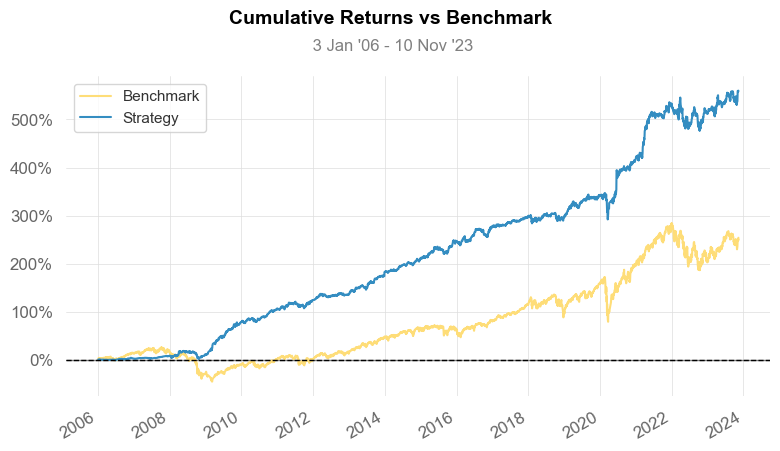

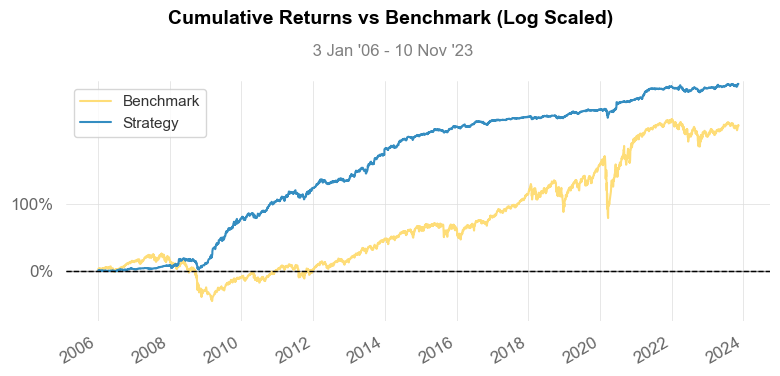

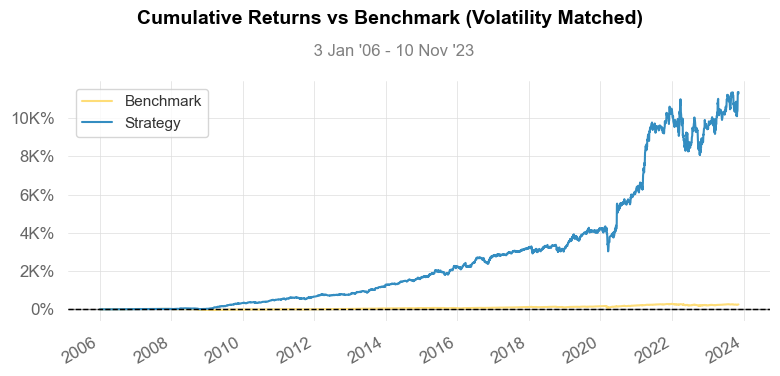

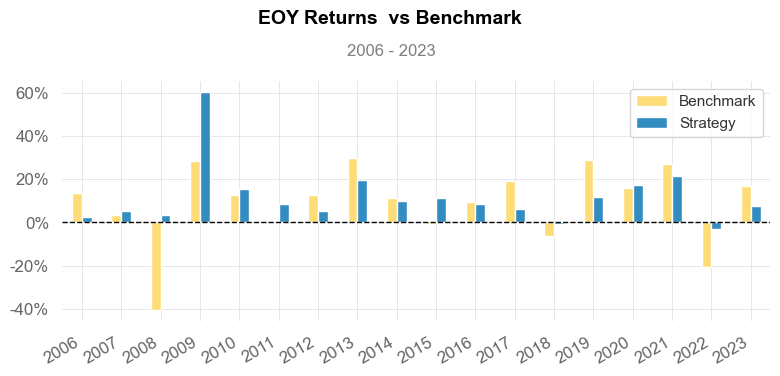

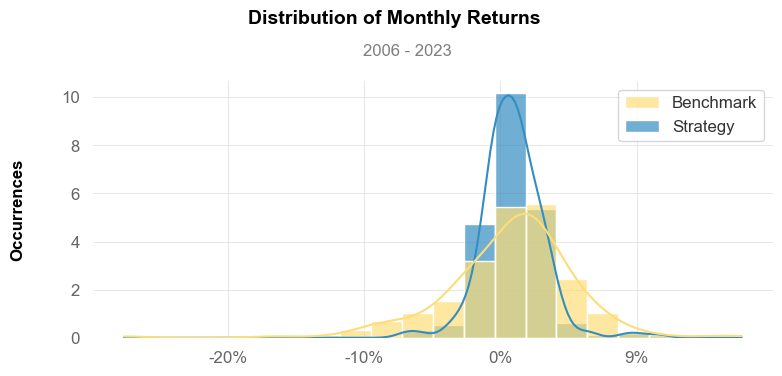

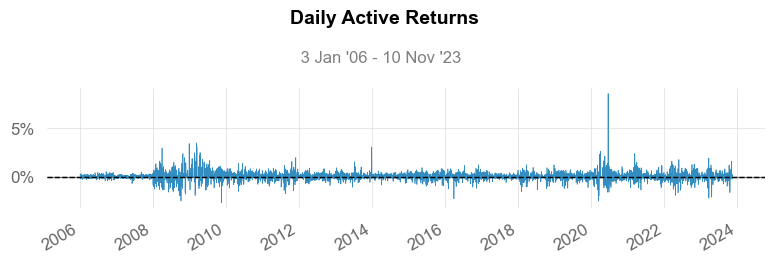

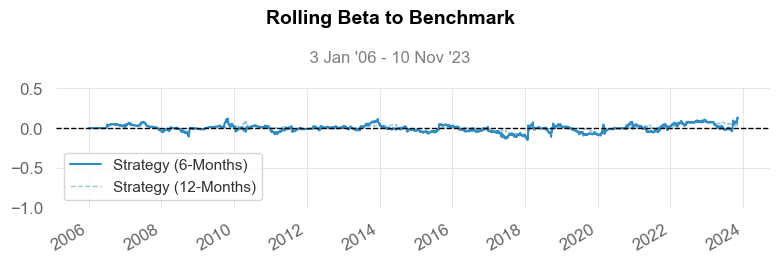

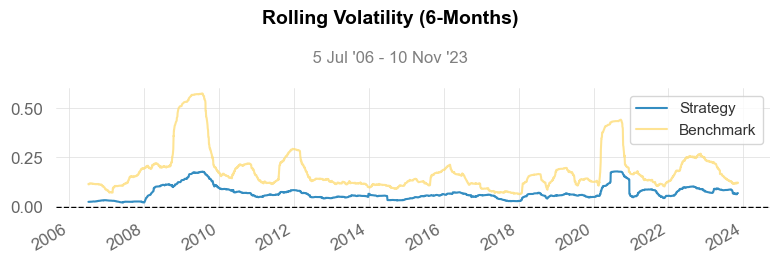

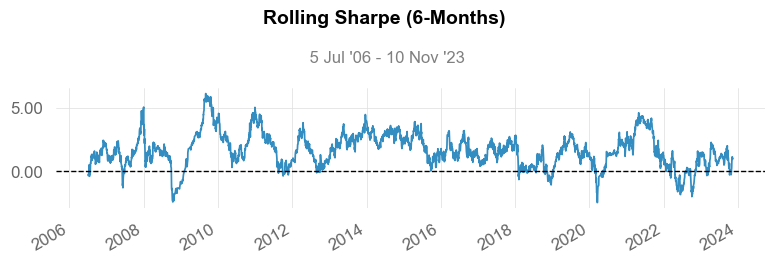

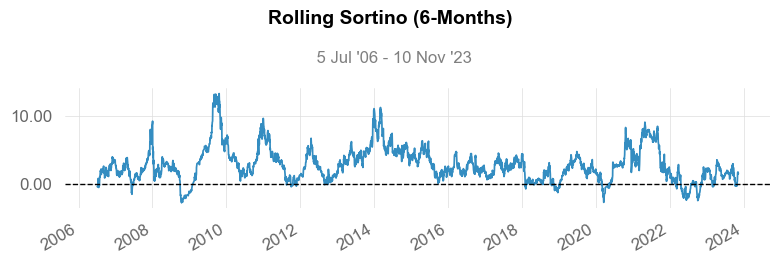

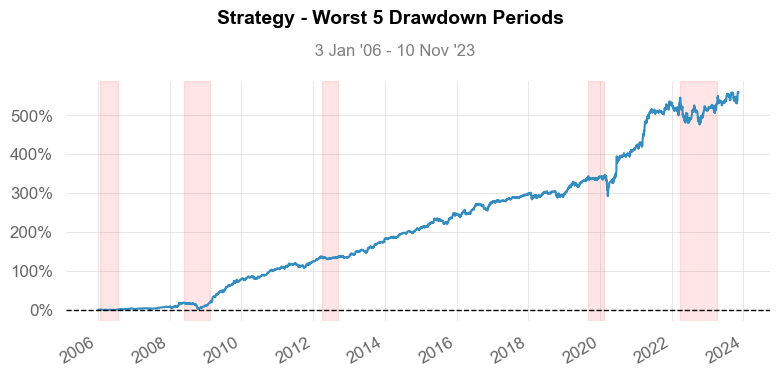

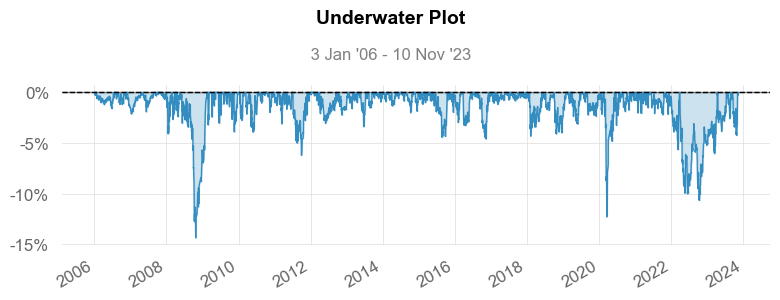

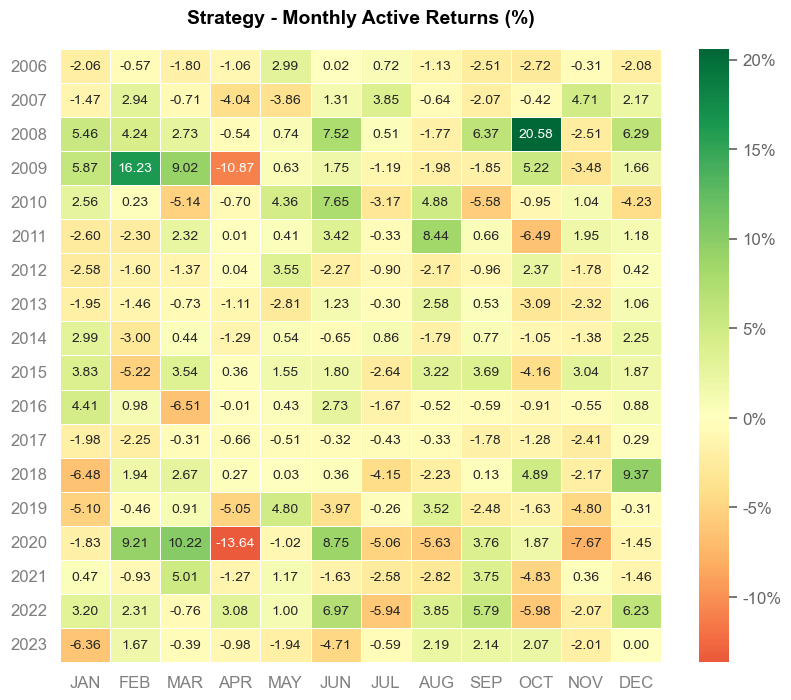

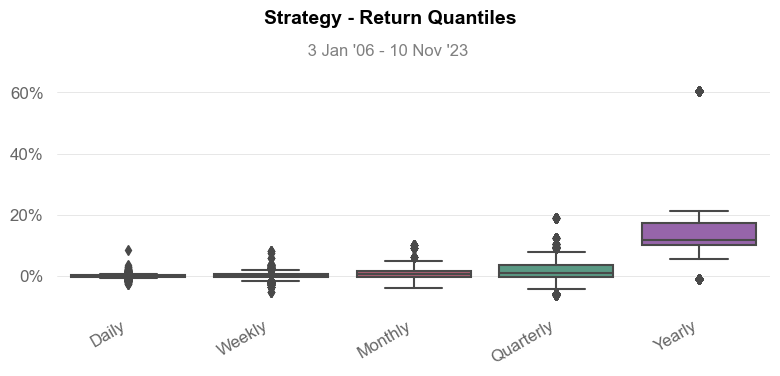

In [507]:
qs.reports.full(comb_factor_total, 'SPY')